# Supervised ANNs for Mutual Information Investigation
## Thomas Possidente

### Imports and Initializations

In [87]:
# ANN Building and Visualization Imports
import keras
from keras import backend as K
from keras import optimizers, losses
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import tensorflow as tf
from keras.callbacks import LambdaCallback
from keras.utils import to_categorical
import matplotlib.pyplot as plt



# Standard Imports
import pandas as pd
import numpy as np
import math

# Value Inits - Specify as needed
num_inputs = int(5000)  # number of dummy images in set
size = int(16)          # Dimension of each dummy image should be size*size
RF_size = int(4)        # Dimensions of the RF to be analyzed should be RF_size*RF_size
noise = 0.99             # percentage (as decimal) of input values that will be flipped 

# Value Inits - Leave these alone
num_of_RFs = int((size*size) / (RF_size*RF_size))
inputs_by_RF = np.empty([(num_inputs * size), size])


### Reading in Data

In [88]:
inputs = pd.read_csv('test.csv')
inputs = inputs.drop('X1', axis = 0) # Taking out col names
inputs = inputs.apply(pd.to_numeric)  # converting to floats

inputs = inputs.values # convert to np ndarray
inputs = inputs.reshape(num_inputs, size, size,1) # reshape to desired dims (5000 examples, 16*16 image, 1 channel)
flattened_inputs = inputs.reshape(num_inputs, size*size)

### Creating Labels

In [89]:
labels = np.zeros(np.shape(flattened_inputs)[0])
storage = np.zeros(np.shape(flattened_inputs))
count = 0

for i in range(np.shape(flattened_inputs)[0]):
    if(~((flattened_inputs[i] == storage).all(1).any())):
        labels[i] = count
        storage[i] = flattened_inputs[i]
        count += 1
    elif((flattened_inputs[i] == storage).all(1).any()):
        label_index = np.where((flattened_inputs[i] == storage).all(1))
        correct_label = labels[label_index]
        storage[i] = flattened_inputs[i]
        labels[i] = correct_label[0]
        
labels = labels.astype(int)
labels = to_categorical(labels)

    

### Adding Noise to Inputs

In [90]:
for n in range(np.shape(flattened_inputs)[0]):
    indices_to_flip = np.random.choice(int(size*size), math.ceil(size*size * noise), replace = False)
    flattened_inputs[indices_to_flip] = 1 - flattened_inputs[indices_to_flip]

inputs = flattened_inputs.reshape(num_inputs, size, size, 1)


### Building Network

In [91]:
model = Sequential()
model.add(Conv2D(input_shape = (16,16,1), filters=4, kernel_size = RF_size, strides = RF_size, activation = 'relu'))
model.add(Flatten())
model.add(Dense(256, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 4, 4, 4)           68        
_________________________________________________________________
flatten_18 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               16640     
Total params: 16,708
Trainable params: 16,708
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(optimizer = optimizers.adam(lr = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [93]:
history = model.fit(x = inputs.reshape(num_inputs, size, size, 1), validation_split = 0.25, y = labels, batch_size = 100, epochs = 30)

Train on 3750 samples, validate on 1250 samples
Epoch 1/30
3750/3750 [==============================] - 2s 438us/step - loss: 5.4781 - acc: 0.0243 - val_loss: 5.3243 - val_acc: 0.0752
Epoch 2/30
3750/3750 [==============================] - 1s 169us/step - loss: 5.1344 - acc: 0.1195 - val_loss: 4.8486 - val_acc: 0.1672
Epoch 3/30
3750/3750 [==============================] - 1s 172us/step - loss: 4.5351 - acc: 0.2789 - val_loss: 4.1405 - val_acc: 0.3512
Epoch 4/30
3750/3750 [==============================] - 1s 171us/step - loss: 3.7735 - acc: 0.4643 - val_loss: 3.3216 - val_acc: 0.4784
Epoch 5/30
3750/3750 [==============================] - 1s 173us/step - loss: 2.9970 - acc: 0.6088 - val_loss: 2.5311 - val_acc: 0.6552
Epoch 6/30
3750/3750 [==============================] - 1s 158us/step - loss: 2.3371 - acc: 0.7429 - val_loss: 1.8911 - val_acc: 0.8216
Epoch 7/30
3750/3750 [==============================] - 1s 169us/step - loss: 1.8435 - acc: 0.8757 - val_loss: 1.4128 - val_acc: 0.9080


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


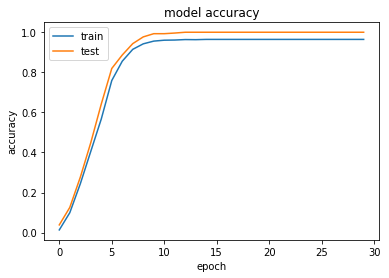

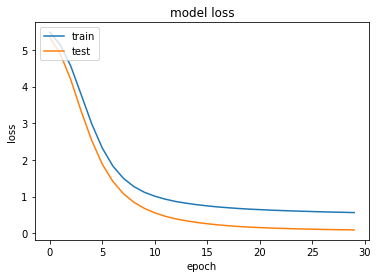

In [86]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()